# Understanding the Demographics & Influence of Technica

### By Raghav Chetal and Sofia Fernandez-Poyatos

<p> Computer Science has always been a generally male-dominated career, with only 18% of all computer scientists being women and 20% of Computer Science students being women at University of Maryland. </p>

![](technica_cover.jpg)

## Our Motivation

[Technica](https://gotechnica.org) is the world's largest all-women and nonbinary hackathon, hosted annually at the University of Maryland. Since its inception in 2015, Technica has been putting a spotlight on women in the computer science workplace and empowering them to succeed. 
<br><br>
We've both been involved with Technica's organization through director and mentor positions. We are interested in understanding Technica's influence in different age groups, studies and states.
<br><br>
We received permission from the Technica organizing team to use several participant registration datasets. In this tutorial, we will focus on 2018's registration data, because it is the most completed. 

This dataset includes information such as:
<br>
* Age
* Major
* School
* Background/Ethnicity
* Gender
* State
* Institution/University
* Retention Rate

## Required Libraries¶
Here are the libraries we used for our tutorial and how we used them:
<br>
* _pandas_ : a data analysis toolkit which makes storing and accessing data easier
* _numpy_ : a package for mathematical computing
* _seaborns_ : creating graphs (pie charts, bar charts, etc.)
* _re_ : using regex to select preferred word
* _beautifulsoup4_ : to scrape web for coordinates of states to plot on map
* _requests_ : to access url page to scrape for bs4
* _folium_ : creating map visualizations of hackers
* _sklearn_ : making regressions and doing statistical analysis

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import re
from bs4 import BeautifulSoup
import requests
import pprint as pp

%matplotlib inline
matplotlib.style.use("ggplot")

data2017 = pd.read_csv("technica_data_2017.csv")
data2018 = pd.read_csv("technica_data_2018.csv")
data2019 = pd.read_csv("technica_data_2019.csv")

## Data Curation
Before uploading the CSV files we removed any private data (i.e. participants name, email and t-shirt size). Here we will remove any unecessary data (food restrictions, pronouns, tokens, and unnamed columns) that do not contribute to our analysis.

In [2]:
clean_data = data2018.drop(['Preferred Pronouns', 'Food Restrictions','Unnamed: 14','University'], axis = 'columns')
clean_data.head()

,Age,Birthday,Gender Identity,Backgrounds,School Level,Graduation Year,First Hackathon?,First Technica?,Location,Institution,Major,State,Country (non-USA),Tech + Research Track?
0,22,5/18/96,Female,Hispanic or Latino,College (Undergraduate),2019,True,True,Olney,University of Maryland College Park,Environmental Science and Technology,Maryland,NaN,True
1,17,5/15/01,Female,Asian / Pacific Islander,High School,2019,True,True,Ellicott City,NaN,NaN,Maryland,NaN,False
2,21,10/25/97,Female,Prefer not to answer,College (Undergraduate),2020,False,True,Gaithersburg,University of Maryland College Park,Computer Science,Maryland,NaN,False
3,20,9/22/98,Female,Asian / Pacific Islander,College (Undergraduate),2021,True,True,College Park,University of Maryland College Park,Mechanical Engineering,Maryland,NaN,True
4,20,3/12/98,Female,Asian / Pacific Islander,College (Undergraduate),2020,False,True,College Park,University of Maryland College Park,Bioengineering,Maryland,NaN,True


The 2018 data is the most complete dataset that we have, so in order to run models on the different datasets, we have to modify the other datasets to match the headers and calculate missing information. The following code will fix the 2019 dataset.

In [3]:
clean_2019_data = data2019.drop(['Preferred Pronouns', 'Other.1', 'Please type in your university.', 'Unnamed: 25', 'Unnamed: 26'], axis = 'columns')
clean_2019_data

# Calculating age based on birthday
now = pd.Timestamp('now')
clean_2019_data['Birthday'] = pd.to_datetime(clean_2019_data['Birthday'], format='%m/%d/%y')
clean_2019_data['Birthday'] = clean_2019_data['Birthday'].where(clean_2019_data['Birthday'] < now, clean_2019_data['Birthday'] -  np.timedelta64(100, 'Y'))
clean_2019_data['Age'] = (now - clean_2019_data['Birthday']).astype('<m8[Y]')

# Combining all Backgrounds into one series
clean_2019_data['Backgrounds'] = clean_2019_data[clean_2019_data.columns[3:11]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

# Combine all Genders into one series
clean_2019_data['Gender Identity'] = clean_2019_data[clean_2019_data.columns[1:3]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

clean_2019_data.head()

,Birthday,Gender Identity,Other,American Indian or Alaska Native,Asian / Pacific Islander,Black or African American,Hispanic or Latino,Middle Eastern or North African,Native Hawaiian or Other Pacific Islander,White/Caucasian,...,School Level,What is the name of your school?,What institution do you attend?,Major,Please type in your major.,What is your expected year of graduation?,First Technica?,First Hackathon?,Age,Backgrounds
0,1998-08-13,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White/Caucasian,...,College (Undergraduate),NaN,University of Maryland College Park,Aerospace Engineering,NaN,2020.0,False,True,21.0,White/Caucasian
1,2003-05-14,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White/Caucasian,...,High School,Montgomery Blair High School,NaN,NaN,NaN,NaN,True,NaN,16.0,White/Caucasian
2,1998-05-23,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,White/Caucasian,...,College (Undergraduate),NaN,University of Maryland College Park,Psychology,NaN,2020.0,True,NaN,21.0,White/Caucasian
3,2006-08-29,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Middle School,Lime Kiln,NaN,NaN,NaN,NaN,True,NaN,13.0,
4,1998-04-10,Female,NaN,NaN,Asian / Pacific Islander,NaN,NaN,NaN,NaN,White/Caucasian,...,College (Undergraduate),NaN,University of Maryland College Park,Electrical Engineering,NaN,2020.0,True,NaN,21.0,"Asian / Pacific Islander,White/Caucasian"


In [4]:
clean_2017_data = data2017
clean_2017_data.head()

,Age,Gender Identity,Backgrounds,First Hackathon?,Major,Institution
0,18,Female,Asian,No,Computer Science,University Of Maryland
1,22,Female,Hispanic or Latino,No,NaN,NaN
2,18,Female,Asian,Yes,Biochemistry,University of Maryland College Park
3,14,Female,Black or African American,No,NaN,Western School of Technology and Environmental...
4,25,Female,Asian,No,Computer Science,UMBC


In [5]:
datasets = [clean_2017_data, clean_data, clean_2019_data]
full_datasets = [clean_data, clean_2019_data]
data_years = [2017, 2018, 2019]
full_data_years = [2018, 2019]

## General Understand of User Data
We are going to create several graphs in order to have an understanding of what kinds of participants attend Technica.
<br> <br>
First we will take a look at what kind of age range of people are registered and interest in Technica using a bargraph and take a look at what kinds of majors as well as what kinds of majors are registering through a bar graph.



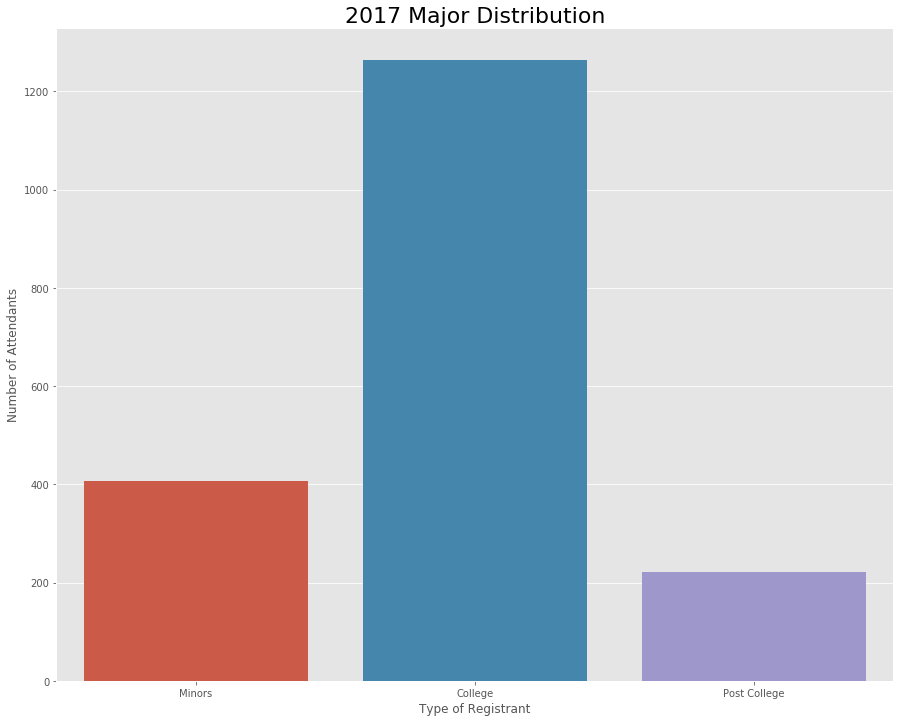

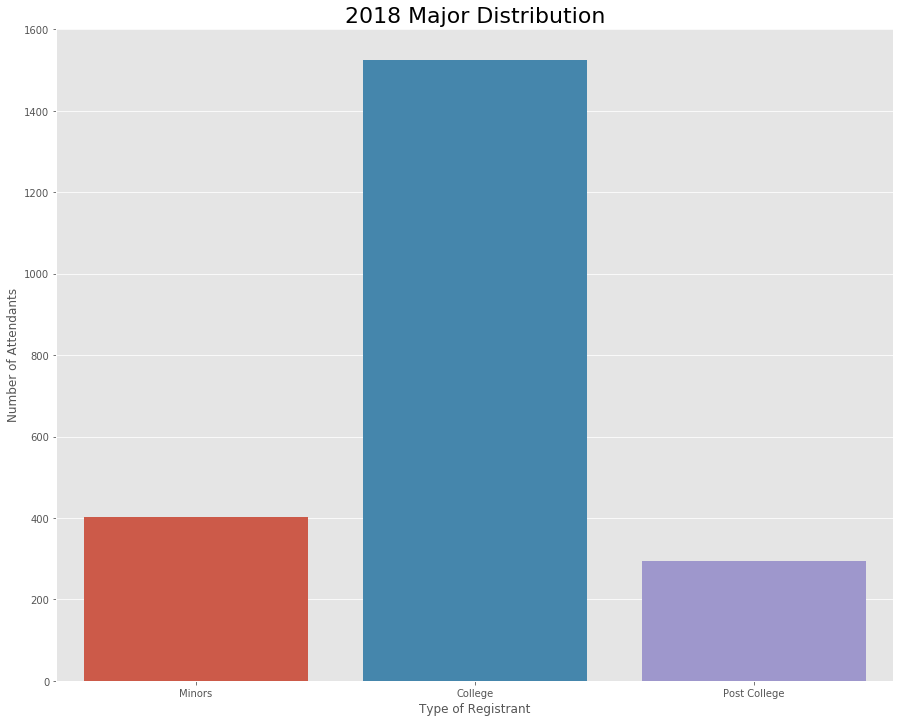

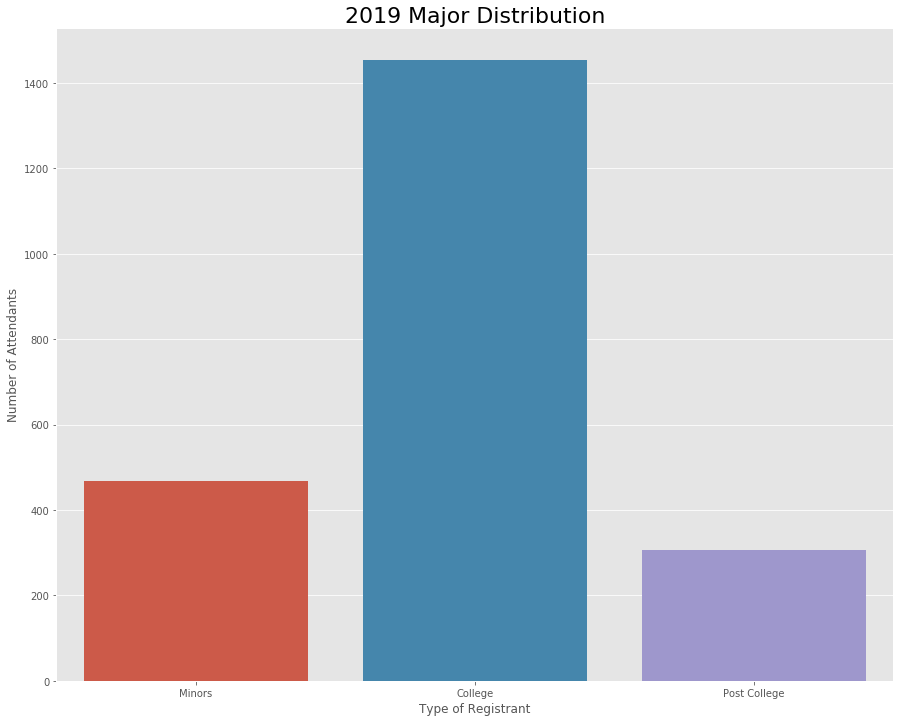

In [6]:
i = 0

for data in datasets:
    #majors
    minors = 0
    college = 0
    post_college = 0

    ages = data['Age'].dropna()
    for age in ages:
        if int(age) <18:
            minors += 1
        elif int(age) >= 18 and int(age) <= 23:
            college += 1
        else:
            post_college += 1


    x = ['Minors', 'College', 'Post College']
    y = [minors, college, post_college]

    plt.figure(figsize=(15,12))
    my_plot = sns.barplot(x, y);
    my_plot.set(xlabel ='Type of Registrant', ylabel = 'Number of Attendants') 
    plt.title(str(data_years[i]) + ' Major Distribution', fontsize = 22)
    i += 1
    

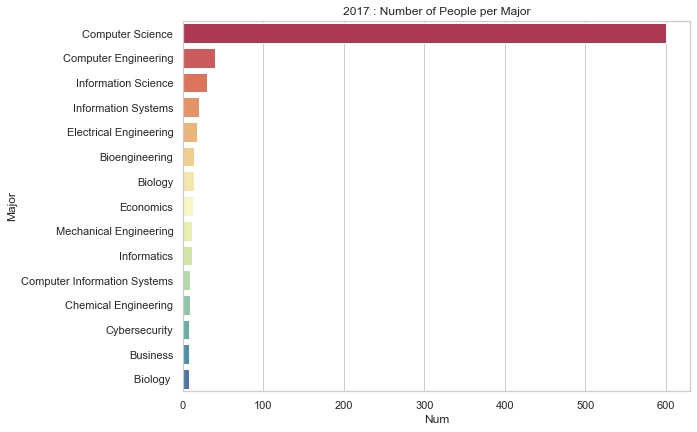

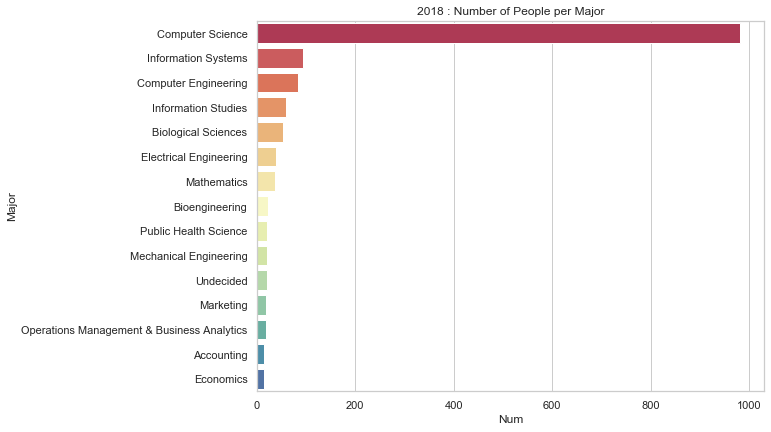

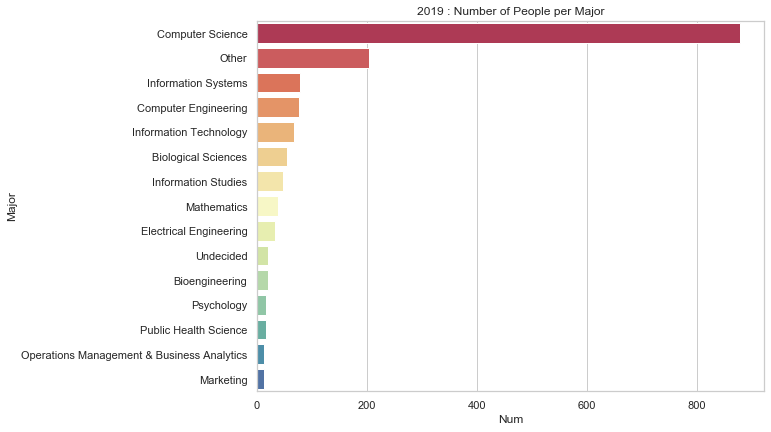

In [7]:
i = 0

for data in datasets:
    df_major = pd.DataFrame(data['Major'].value_counts())
    df_major = df_major.head(15)
    major_clean = df_major.reset_index()
    major_clean.columns = ['Major', 'Num'] 

    sns.set(style="whitegrid")
    plt.figure(figsize=(20,15))
    the_grid = GridSpec(2, 2)

    plt.subplot(the_grid[0, 1],  title=str(data_years[i]) + ' : Number of People per Major')
    sns.barplot(x='Num',y='Major', data=major_clean, palette='Spectral')
    i += 1

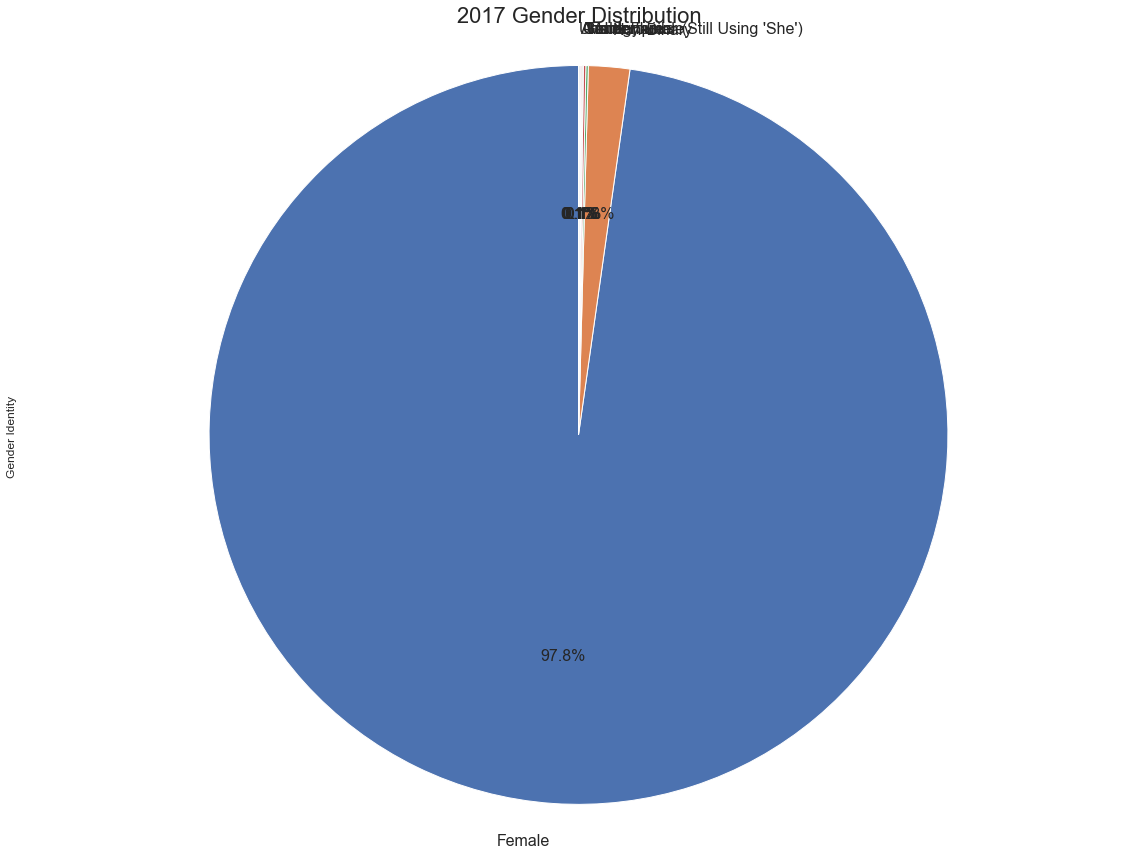

Female                             1843
Non-Binary                           34
Male                                  2
Trans Female                          2
Genderqueer (Still Using 'She')       1
Genderfluid                           1
Androgynous                           1
Unsure                                1
Name: Gender Identity, dtype: int64


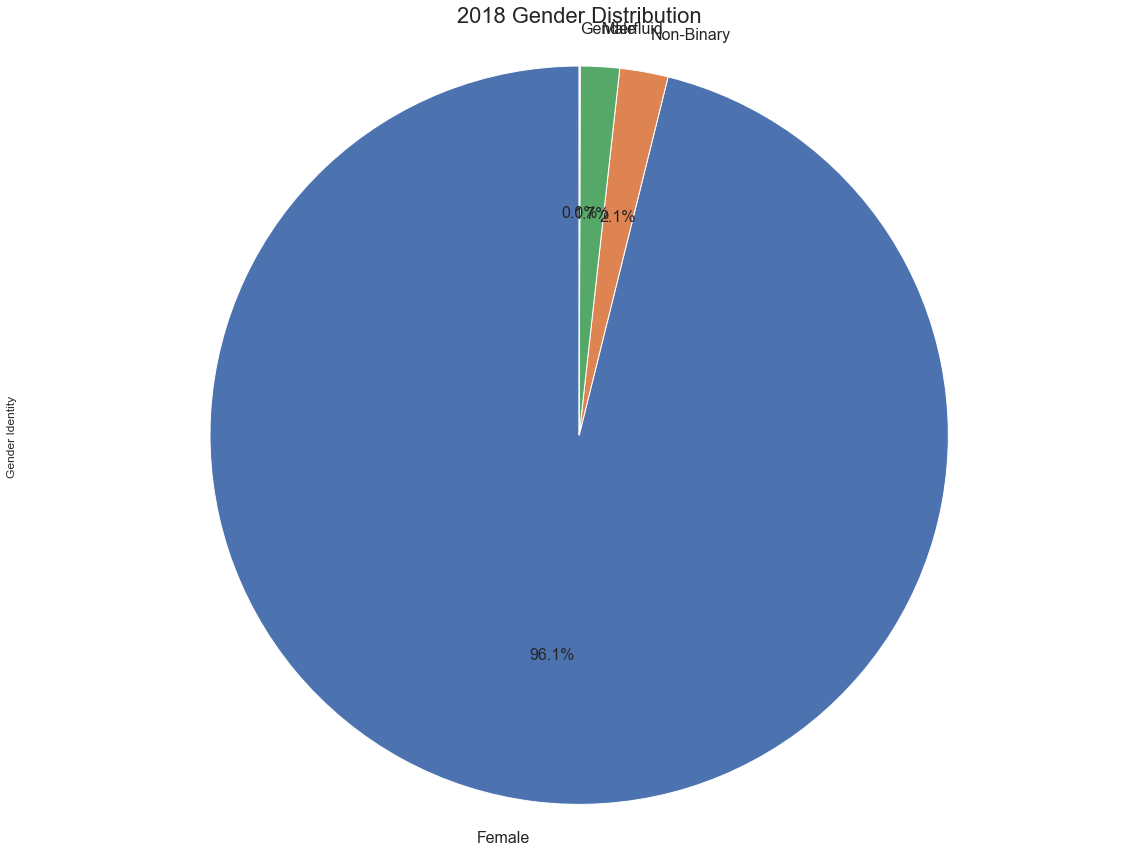

Female         2135
Non-Binary       47
Male             38
Genderfluid       1
Name: Gender Identity, dtype: int64


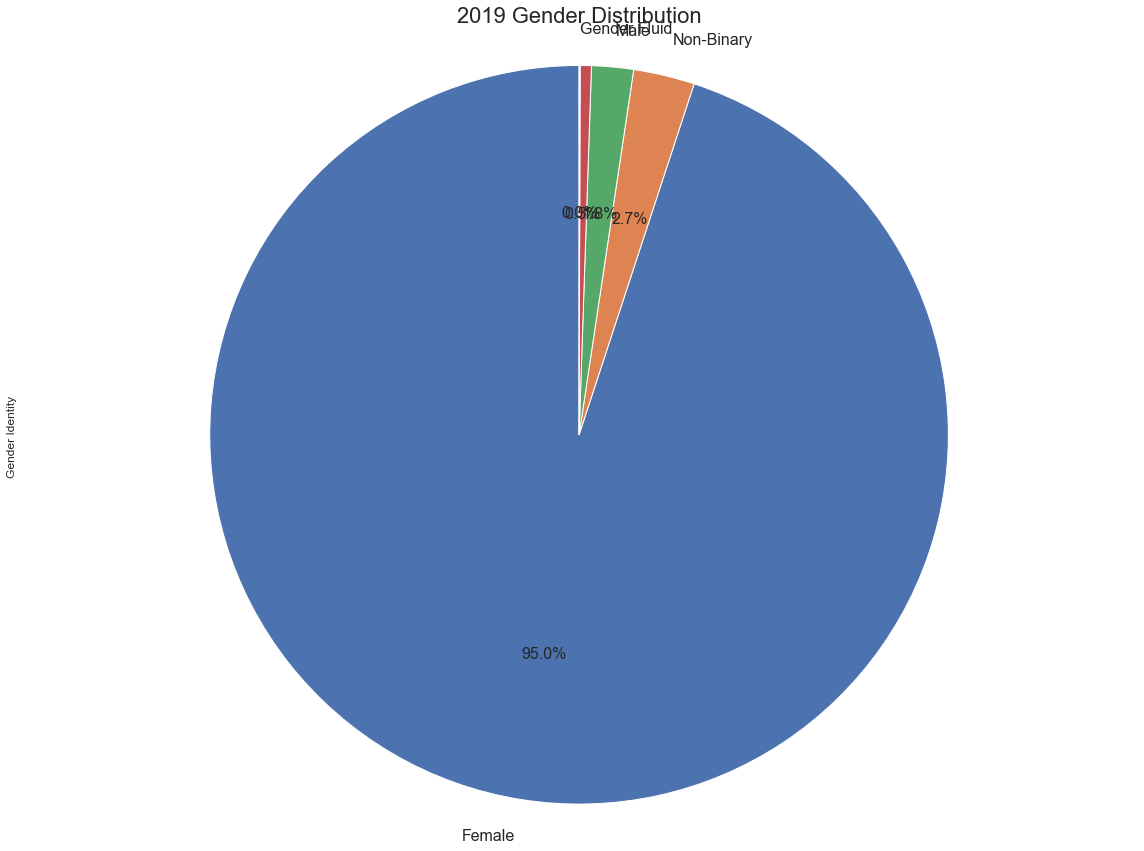

Female          2128
Non-Binary        60
Male              41
                  11
Gender Fluid       1
Name: Gender Identity, dtype: int64


In [8]:
i = 0

for data in datasets:
    # Removes invalid answers, surveys were self-fill, so there is some invalid data
    occurrences = data['Gender Identity'].str.title().value_counts()

    # Creates a Pie Chart of the Gender Identity data
    plt.figure(2, figsize=(20,15))
    occurrences.plot.pie(y = occurrences.index,
               shadow=False, 
               startangle=90,
               autopct='%1.1f%%',
            textprops={'fontsize': 16})

    plt.axis('equal')
    plt.title(str(data_years[i]) + ' Gender Distribution', fontsize = 22)
    plt.show()
    i += 1
    
    print(occurrences)

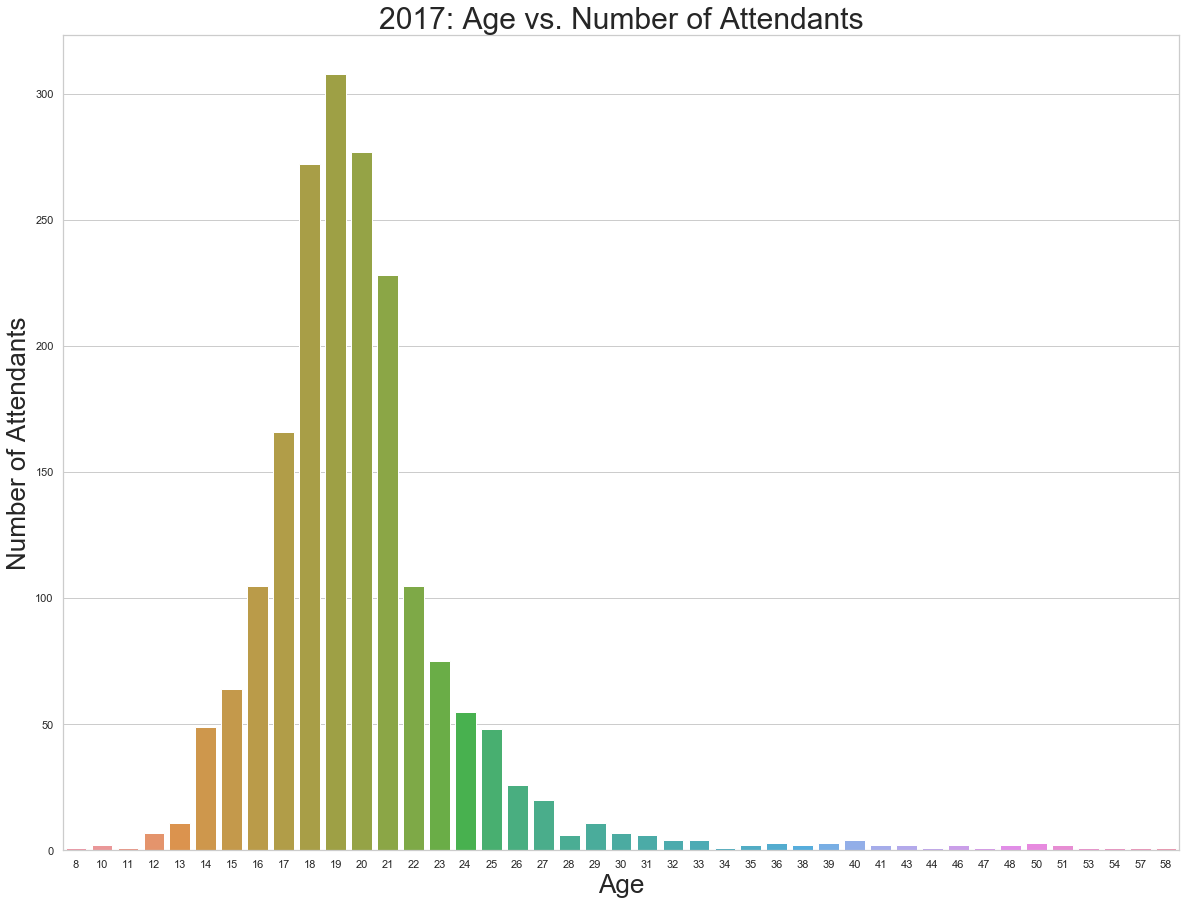

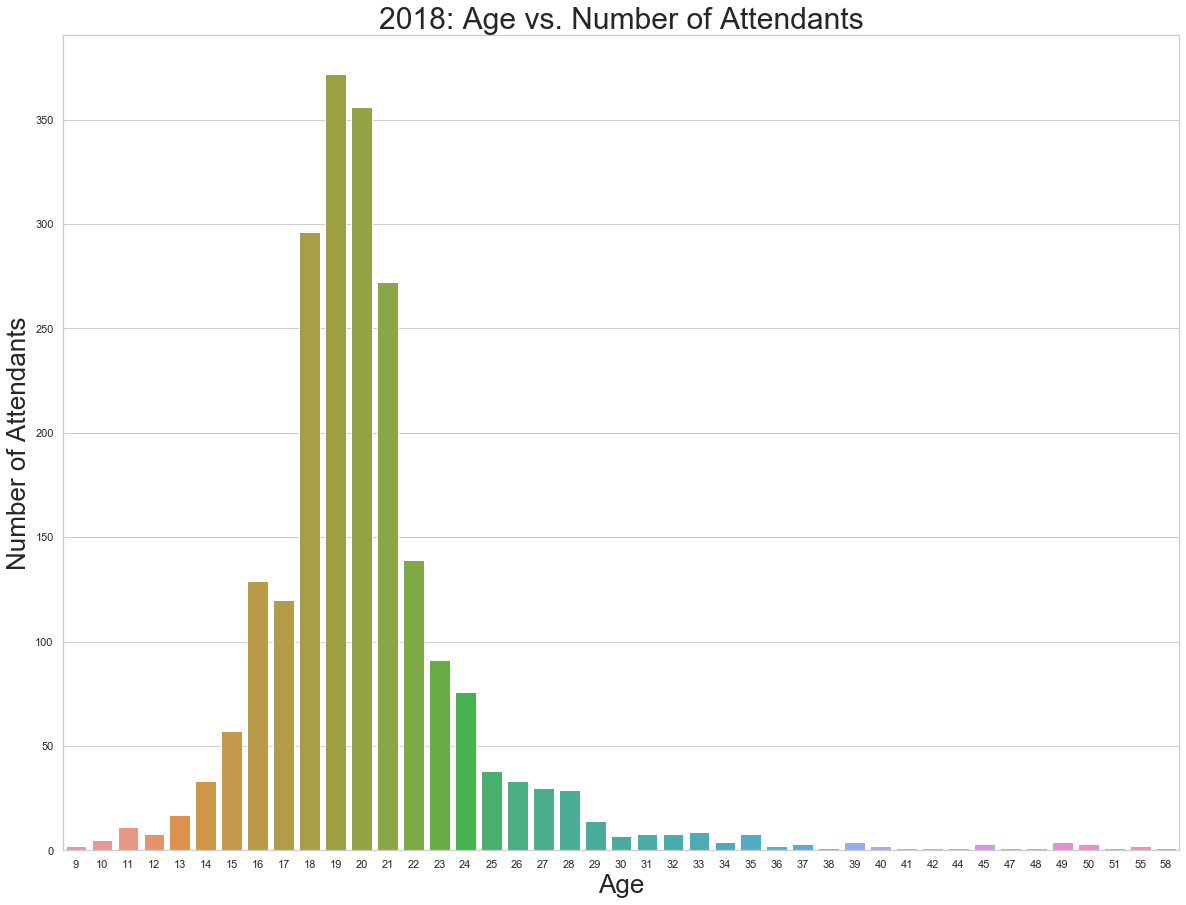

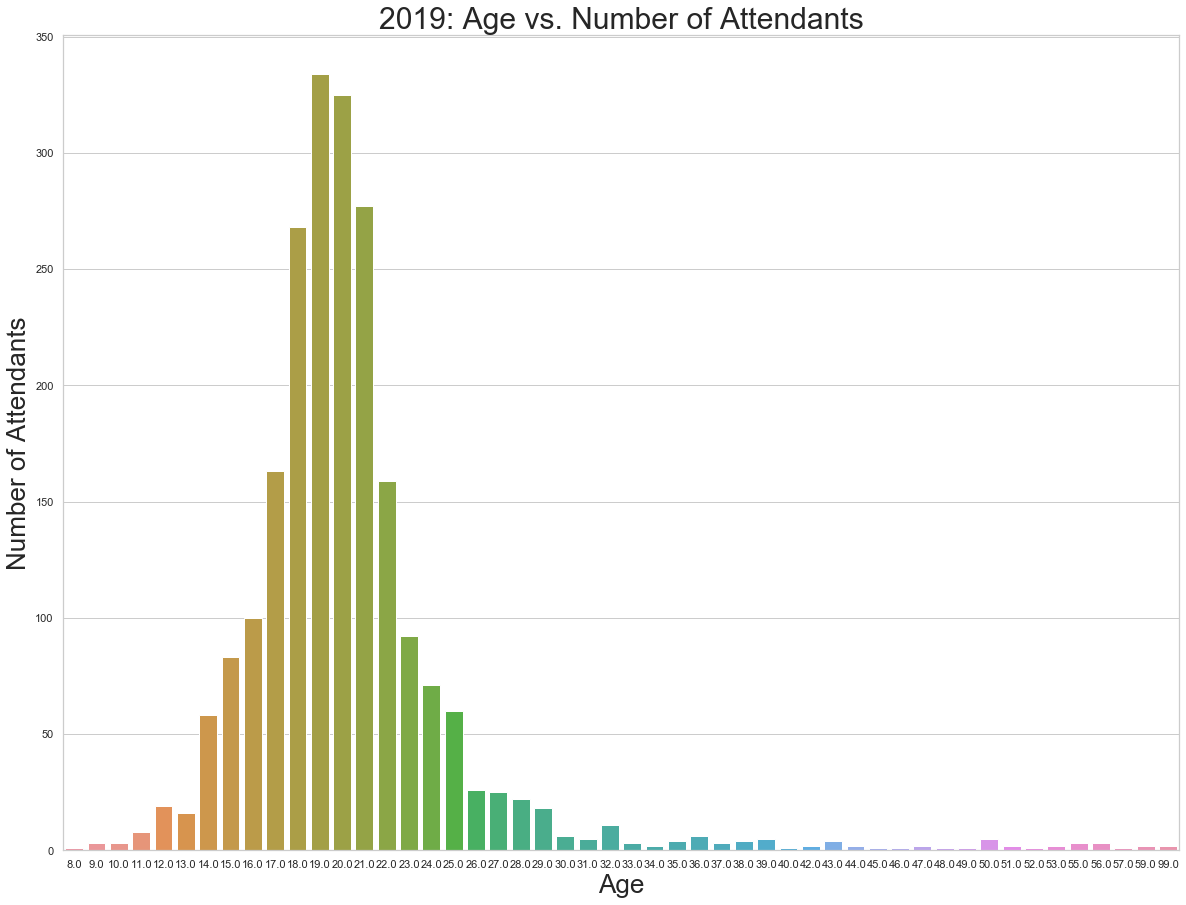

In [9]:
i = 0

for data in datasets:
    # Removes invalid answers, surveys were self-fill (Remove ages under 5)
    age_fix = data[data['Age'] > 5]
    occurrences = age_fix['Age'].value_counts()

    # Plot the Barplot
    plt.figure(figsize=(20,15))
    ax = sns.barplot(x=occurrences.keys(), y=occurrences.values, data=clean_data)
    plt.title(str(data_years[i]) + ': Age vs. Number of Attendants', fontsize = 30)
    plt.ylabel('Number of Attendants', fontsize = 26)
    plt.xlabel('Age', fontsize = 26)
    plt.show()
    
    i += 1

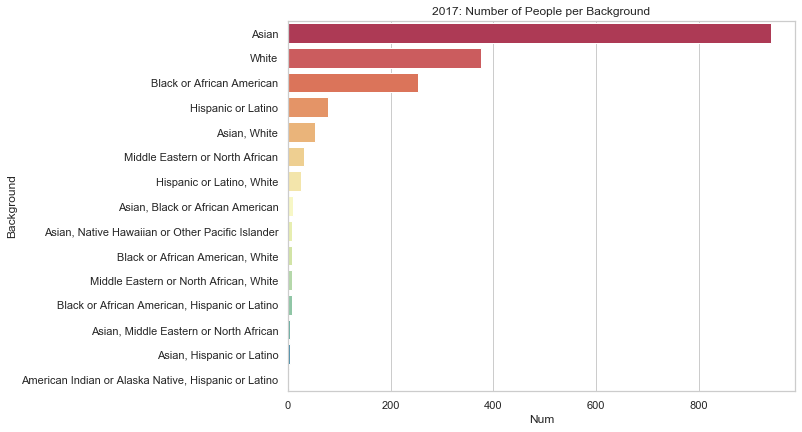

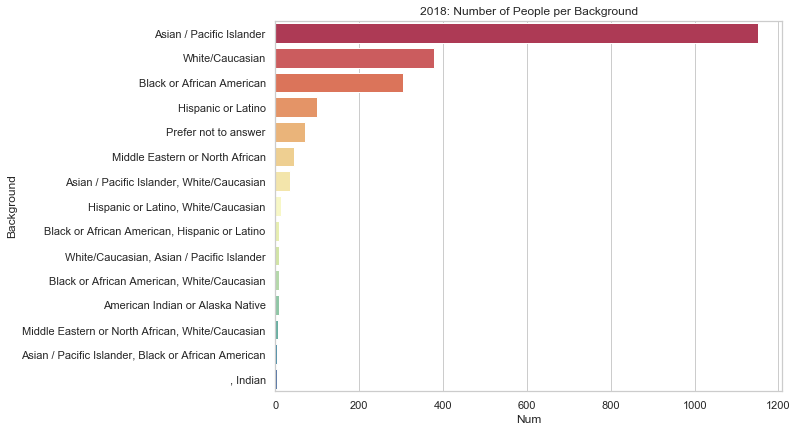

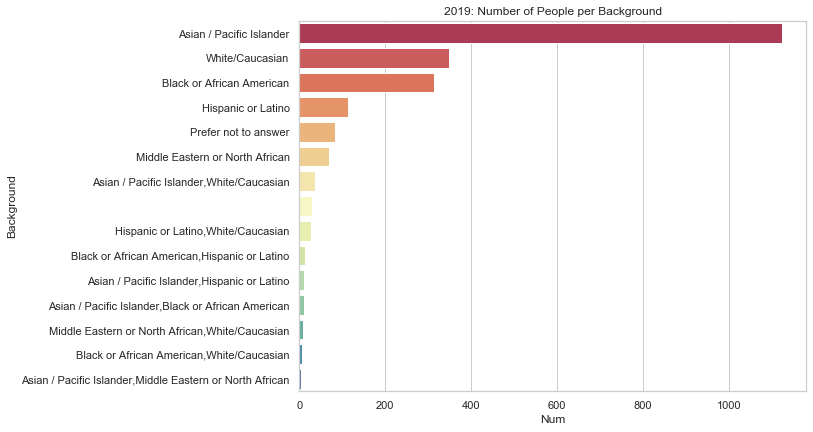

In [10]:
i = 0

for data in datasets:    
    df_background = pd.DataFrame(data['Backgrounds'].value_counts())
    df_background = df_background.head(15)
    background_clean = df_background.reset_index()
    background_clean.columns = ['Background', 'Num'] 

    sns.set(style="whitegrid")
    plt.figure(figsize=(20,15))
    the_grid = GridSpec(2, 2)

    plt.subplot(the_grid[0, 1],  title=str(data_years[i]) + ': Number of People per Background')
    sns.barplot(x='Num',y='Background', data=background_clean, palette='Spectral')
    plt.show()
    
    i += 1

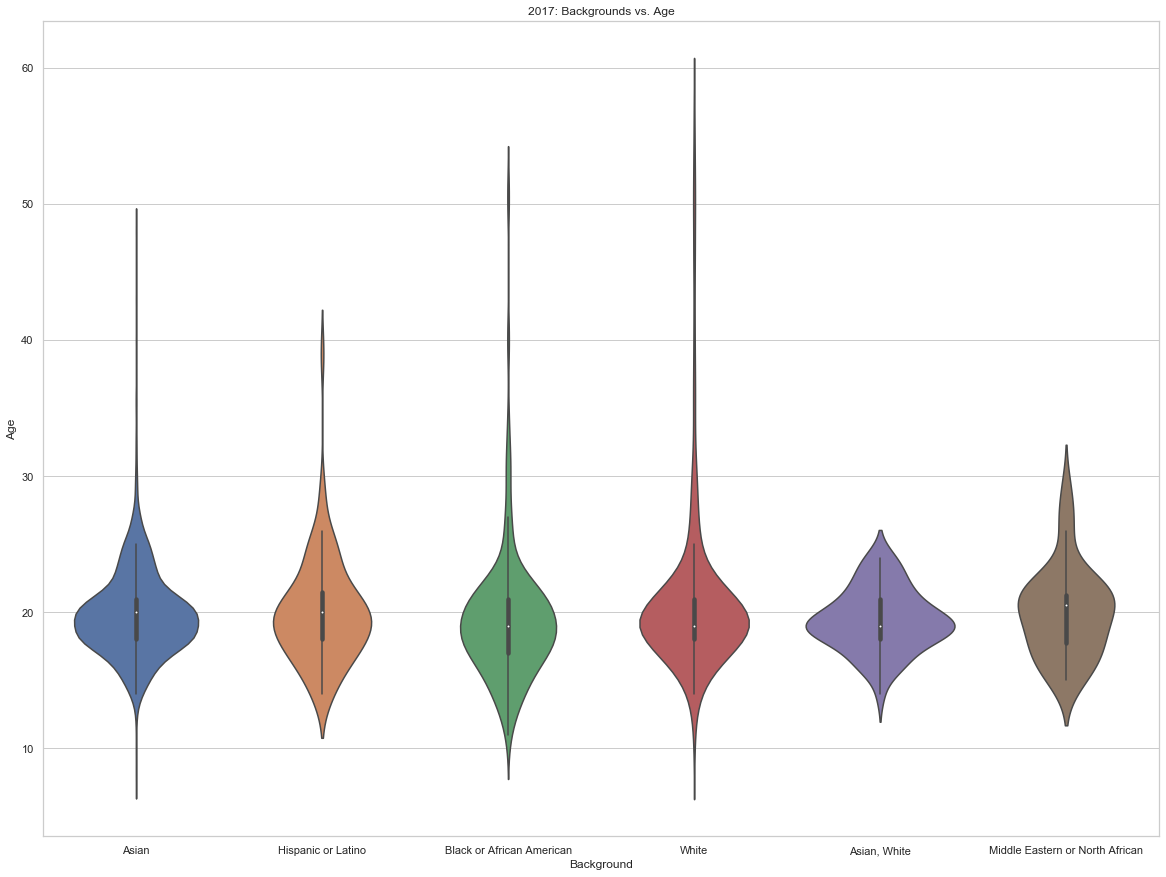

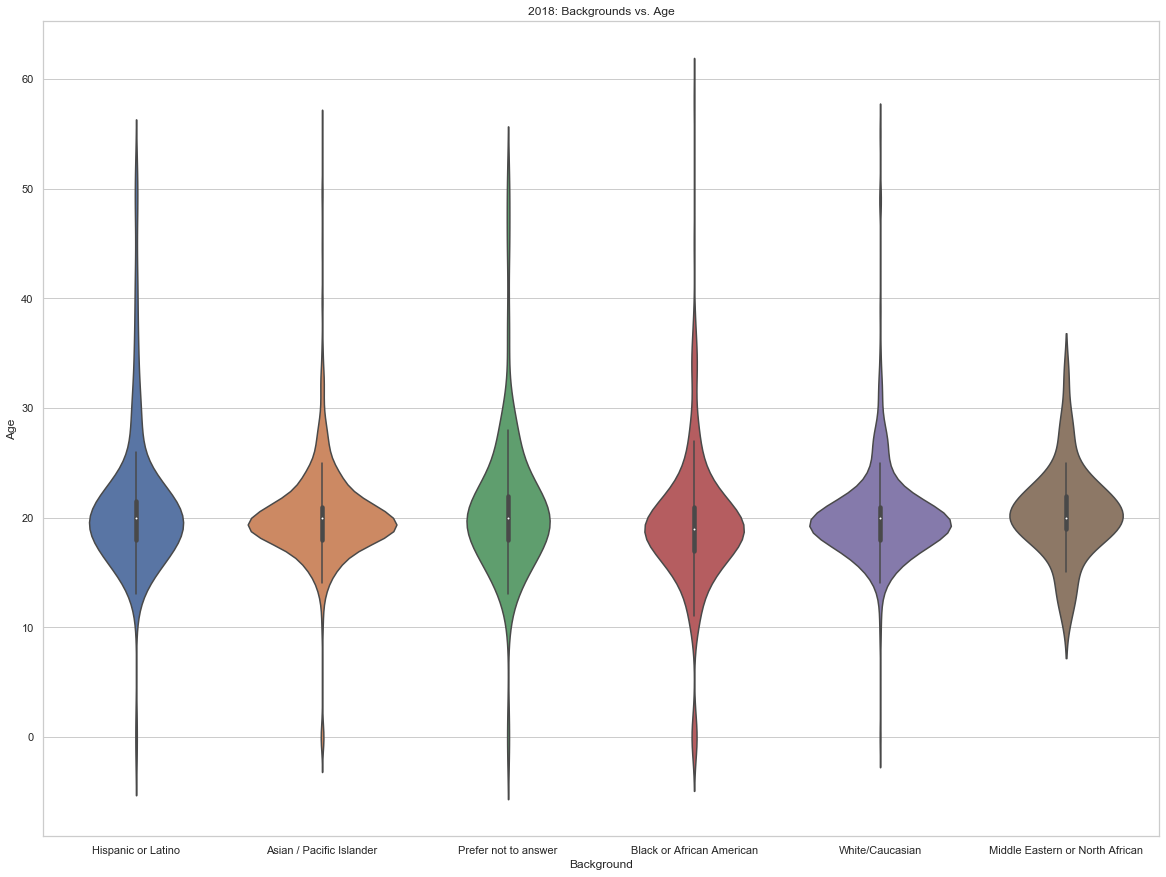

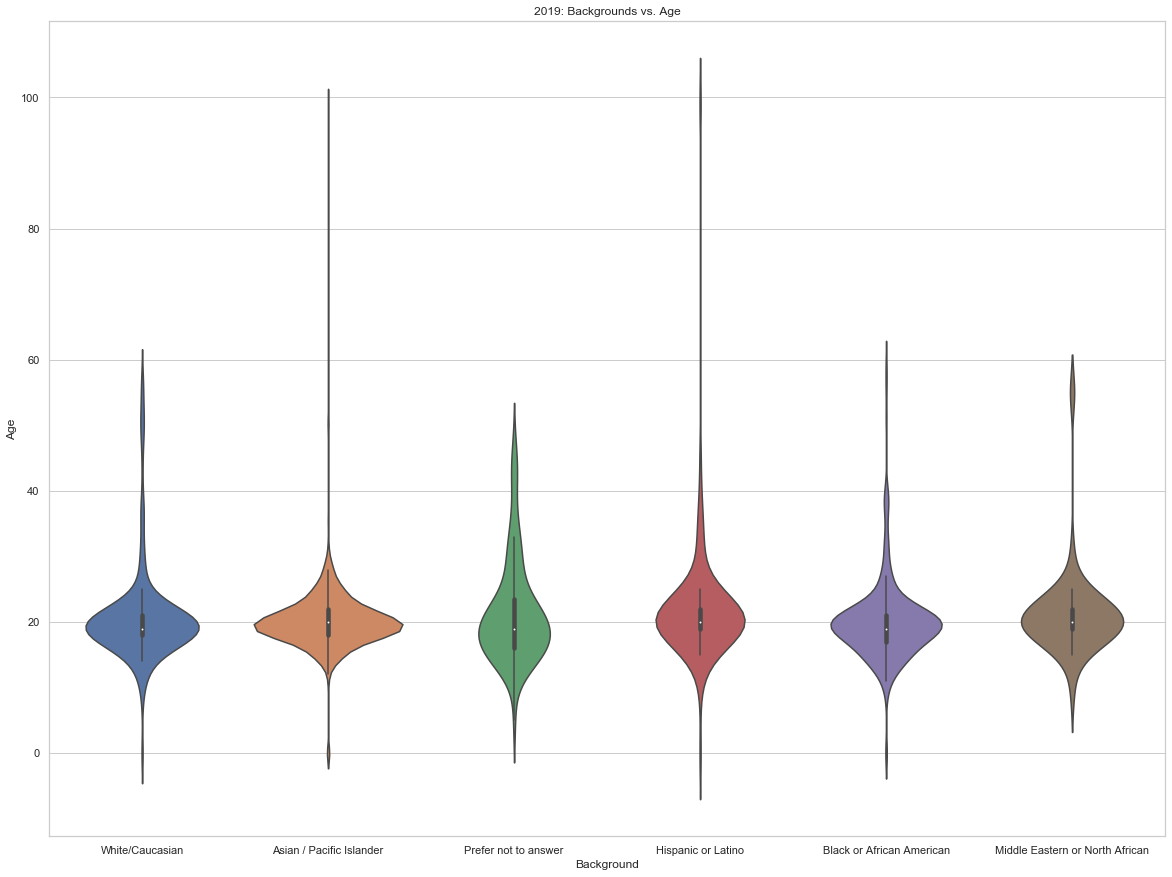

In [11]:
i = 0

for data in datasets: 
    # Get the most common backgrounds (Limit to 6 for comparison between years)
    common_backgrounds = pd.DataFrame(data['Backgrounds'].value_counts())
    common_backgrounds = common_backgrounds[0:6]
    keys = common_backgrounds['Backgrounds'].keys()

    # Limit the dataset to the most common backgrounds
    limited_backgrounds = data[data['Backgrounds'].isin(keys)]
    limited_backgrounds

    # Create a violin plot of the most common backgrounds and their respective ages
    plt.figure(figsize=(20,15))
    ax = sns.violinplot(x='Backgrounds', y='Age', data = limited_backgrounds)
    ax.set(title=str(data_years[i]) + ': Backgrounds vs. Age', xlabel='Background', ylabel='Age')
    plt.show()
    
    i += 1

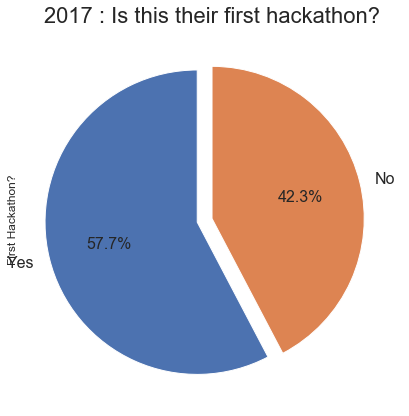

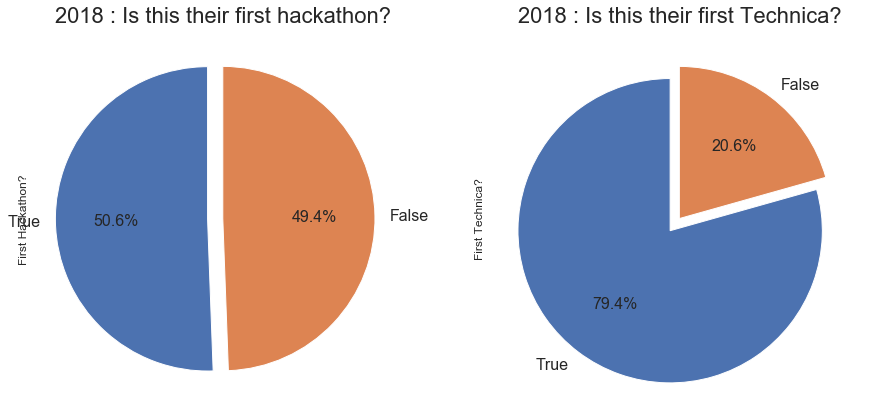

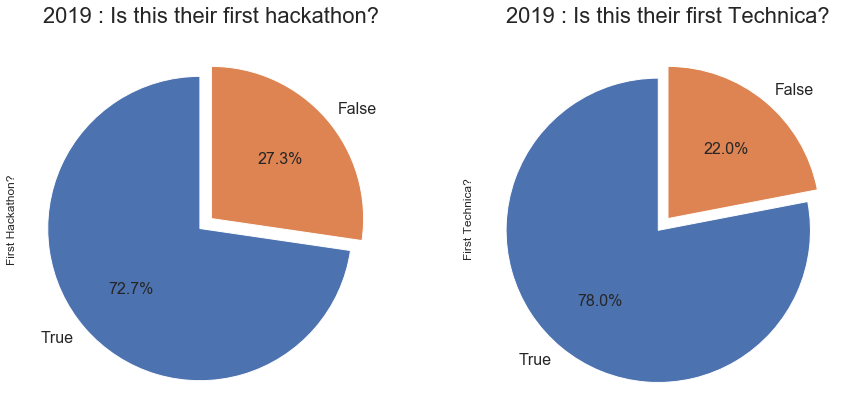

In [12]:
i = 0

# 2017 data does not have the "first Technica" question, so manually computing the first hackathon alone
occurrences3 = clean_2017_data['First Hackathon?'].value_counts()
occurrences3.plot.pie(y=occurrences3.index,
                      shadow=False, 
                      explode=(0.1, 0),
                      startangle=90,
                      autopct='%1.1f%%',
                      figsize=(10,7),
                      textprops={'fontsize': 16})

plt.title('2017 : Is this their first hackathon?', fontsize = 22)
plt.show()
          
for data in full_datasets:     
    # Removes invalid answers, surveys were self-fill, so there is some invalid data
    occurrences = data['First Hackathon?'].value_counts()
    occurrences2 = data['First Technica?'].value_counts()

    # Creates a Pie Chart of the Gender Identity data

    plt.axis('equal')
    ax1 = plt.subplot2grid((1,2),(0,0))
    occurrences.plot.pie(y=occurrences.index,
            shadow=False, 
            explode=(0.1, 0),
            startangle=90,
            autopct='%1.1f%%',
            figsize=(15,12),
            textprops={'fontsize': 16})

    plt.title(str(full_data_years[i]) + ' : Is this their first hackathon?', fontsize = 22)

    ax2 = plt.subplot2grid((1,2),(0,1))
    occurrences2.plot.pie(y=occurrences2.index,
            shadow=False, 
            explode=(0.1, 0),
            startangle=90,
            autopct='%1.1f%%',
            figsize=(15,12),
            textprops={'fontsize': 16})

    plt.title(str(full_data_years[i]) + ' : Is this their first Technica?', fontsize = 22)
    plt.show()
    
    i += 1

## Map of Hackers in the USA

In [24]:
save_states = clean_data['State'].dropna().value_counts()
pp.pprint(save_states)

Maryland          963
New York          190
Virginia          189
Pennsylvania      100
New Jersey         77
Other              71
North Carolina     38
Massachusetts      31
California         28
Indiana            25
Florida            23
Texas              16
Washington         13
Georgia            12
Illinois           11
Ohio                7
Michigan            7
West Virginia       6
Wisconsin           5
Rhode Island        5
Delaware            5
Tennessee           5
Utah                4
South Carolina      3
Kentucky            3
Louisiana           3
Alabama             3
Iowa                2
Connecticut         2
Arizona             1
Alaska              1
Minnesota           1
Name: State, dtype: int64


In [25]:
page_info = requests.get("https://www.latlong.net/category/states-236-14.html")
soup_info = BeautifulSoup(page_info.text)

map_coordinates = soup_info.find(class_='col-8')
coordinates = map_coordinates.find_all('td')

our_state_list = save_states.keys()
our_state_values = save_states.values

fresh_state_list = []
lat_list = []
lon_list = []
val_list = []

count = 1
# for coord in coordinates:
for i in range(0,len(coordinates)-1,3):
    #parsing for state name
    info = str(coordinates[i].contents)
        
    find_state = re.findall(r'title="\w+,|title="\w+\s\w+,', info)

    find_state = find_state[0].replace("title=\"", "")
    find_state = find_state[:-1]
    
    if find_state in our_state_list:
        fresh_state_list.append(find_state)
        lon_list.append(coordinates[i+1].contents[0])
        lat_list.append(coordinates[i+2].contents[0])
        val_list.append(save_states[find_state])

map_data = pd.DataFrame({
    'name':fresh_state_list,
    'lat':lat_list,
    'lon':lon_list,
    'val':val_list
})

In [15]:
from folium.plugins import MarkerCluster

map_osm = folium.Map(location=[30, -90], zoom_start=4)

marker_cluster = MarkerCluster().add_to(map_osm)

def cluster_color(num):
    if num <= 10:
        return 'green'
    elif num > 10 and num <= 50:
        return 'lightblue'
    elif num > 50 and num <= 100:
        return 'orange'
    elif num > 100 and num <= 500:
        return 'lightred'
    else:
        return 'darkred'

# Add the datapoints to the map object
for i in range(0,len(map_data)):
    folium.Marker([map_data.iloc[i]['lon'], 
                   map_data.iloc[i]['lat']], 
                  popup=map_data.iloc[i]['name'],
                  icon=folium.Icon(color=cluster_color(map_data.iloc[i]['val']))
                 ).add_to(map_osm)
    
map_osm

In [16]:
save_states = clean_2019_data['State'].dropna().value_counts()
print(save_states.to_string())

Maryland          1226
Virginia           207
New York           184
Pennsylvania       133
Other               93
New Jersey          66
Florida             46
California          42
North Carolina      35
Massachusetts       28
Indiana             25
Georgia             19
Washington          18
Delaware            17
Texas               17
Illinois            16
Ohio                 9
Connecticut          9
South Carolina       8
Rhode Island         7
West Virginia        6
Missouri             4
Michigan             4
Alabama              2
Colorado             2
Wyoming              1
New Hampshire        1
Wisconsin            1
Mississippi          1
Louisiana            1
Tennessee            1
Hawaii               1


In [17]:
page_info = requests.get("https://www.latlong.net/category/states-236-14.html")
soup_info = BeautifulSoup(page_info.text)

map_coordinates = soup_info.find(class_='col-8')
coordinates = map_coordinates.find_all('td')

our_state_list = save_states.keys()
our_state_values = save_states.values

fresh_state_list = []
lat_list = []
lon_list = []
val_list = []

count = 1
# for coord in coordinates:
for i in range(0,len(coordinates)-1,3):
    #parsing for state name
    info = str(coordinates[i].contents)
        
    find_state = re.findall(r'title="\w+,|title="\w+\s\w+,', info)

    find_state = find_state[0].replace("title=\"", "")
    find_state = find_state[:-1]
    
    if find_state in our_state_list:
        fresh_state_list.append(find_state)
        lon_list.append(coordinates[i+1].contents[0])
        lat_list.append(coordinates[i+2].contents[0])
        val_list.append(save_states[find_state])

map_data = pd.DataFrame({
    'name':fresh_state_list,
    'lat':lat_list,
    'lon':lon_list,
    'val':val_list
})

In [18]:
map_osm_2 = folium.Map(location=[30, -90], zoom_start=4)

marker_cluster = MarkerCluster().add_to(map_osm_2)

def cluster_color(num):
    if num <= 10:
        return 'green'
    elif num > 10 and num <= 50:
        return 'lightblue'
    elif num > 50 and num <= 100:
        return 'orange'
    elif num > 100 and num <= 500:
        return 'lightred'
    else:
        return 'darkred'

# Add the datapoints to the map object
for i in range(0,len(map_data)):
    folium.Marker([map_data.iloc[i]['lon'], 
                   map_data.iloc[i]['lat']], 
                  popup=map_data.iloc[i]['name'],
                  icon=folium.Icon(color=cluster_color(map_data.iloc[i]['val']))
                 ).add_to(map_osm_2)
    
map_osm_2